# Horse or human

Horse or human is a smallish binary image recognition dataset. We use it to compare the performance of a fully connected neural network to a convolutional network.

In [1]:
import tensorflow as tf
# if the import doesn't work try "pip install tensorflow_datasets"
# see https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

We import the data set. The method <code>load</code> below does not return the data but an abstract object with which we can access the data. As a consequence we do not load all the data into memory at once, but rather have a access to an object that allows for batch-wise loading of the data. This makes things a bit more complicated, but it's also more flexible and scalable. The <code>load</code> method returns, when asked, information on the data, too. 

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name="horses_or_humans", 
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

print(ds_info)

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='/home/henning/tensorflow_datasets/horses_or_humans/3.0.0',
    download_size=153.59 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)


We learn that the data has format <code>(300,300,3)</code>, which means 300x300 pixels and 3 colour channels (RGB). We can easily have a peek at some samples.

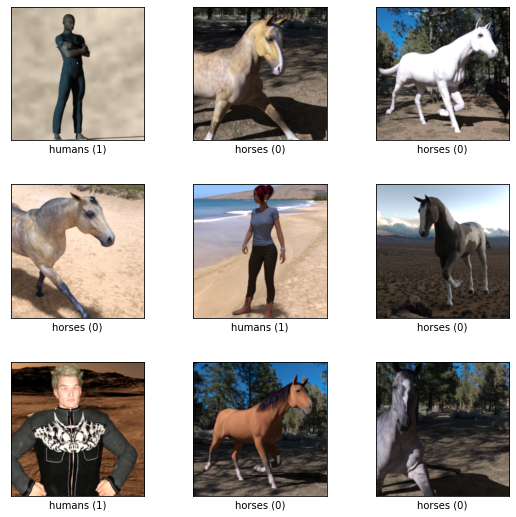

In [3]:
tfds.show_examples(train_ds,ds_info,rows=3,cols=3)
pass

Oh, backgrounds will make this task challenging!

Let's look at the shape of the data. This is surprisingly complicated -- don't ask me why. <code>take(1)</code> generates a data set of with a single sample. However, we still need to iterate over it. To do so, we turn the data set into an iterator, with <code>iter</code>, and then immediately pull out the first element with <code>next</code>.

In [4]:
img,label=next(iter(train_ds.take(1)))
print(img.shape)

(300, 300, 3)


Let's look at how the image is stored. 

In [5]:
img.numpy()[:2,:2,:]

array([[[185, 172, 152],
        [185, 172, 151]],

       [[185, 172, 151],
        [184, 172, 151]]], dtype=uint8)

Aha. Each image is represented by an array of type uint8, which means that in each colour channel the intensities go from 0 to 255. Tensorflow expects floats, and it's best if the data has values in [0,1]. We have to normalise and change the type.

In [6]:
def normalise(image, label):
  return tf.cast(image, tf.float32) / 255., label

# we fix a batch size
batch_size=16

train_ds = train_ds.map(normalise)  # normalise the data
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples) # shuffle between epochs
train_ds = train_ds.batch(batch_size) # data is loaded in batches of 10

test_ds = test_ds.map(normalise) # we have to do the same with the test set
test_ds = test_ds.batch(batch_size)

# let's also fix a number of epochs for training
epochs=10



## Fully connected neural network

We set up three hidden layers, one output unit with logistic activation.

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(300,300,3)),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 30)                8100030   
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 8,101,091
Trainable params: 8,101,091
Non-trainable params: 0
_________________________________________________________________


Note: as the input images are large, there are a huge number of weights for the first hidden layer.

In [8]:
model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
65/65 [==============================] - 5s 62ms/step - loss: 1.2974 - accuracy: 0.6417
Epoch 2/10
65/65 [==============================] - 5s 58ms/step - loss: 0.5481 - accuracy: 0.7770
Epoch 3/10
65/65 [==============================] - 5s 62ms/step - loss: 0.3036 - accuracy: 0.8783
Epoch 4/10
65/65 [==============================] - 6s 64ms/step - loss: 0.3023 - accuracy: 0.8695
Epoch 5/10
65/65 [==============================] - 5s 60ms/step - loss: 0.3601 - accuracy: 0.8549
Epoch 6/10
65/65 [==============================] - 5s 61ms/step - loss: 0.3416 - accuracy: 0.8783
Epoch 7/10
65/65 [==============================] - 5s 60ms/step - loss: 0.1373 - accuracy: 0.9542
Epoch 8/10
65/65 [==============================] - 5s 56ms/step - loss: 0.2657 - accuracy: 0.8919
Epoch 9/10
65/65 [==============================] - 5s 51ms/step - loss: 0.0859 - accuracy: 0.9718
Epoch 10/10
65/65 [==============================] - 5s 58ms/step - loss: 0.1187 - accuracy: 0.9572


In [9]:
model.evaluate(test_ds)

16/16 [==============================] - 0s 20ms/step - loss: 0.5935 - accuracy: 0.8398


[0.5934509038925171, 0.83984375]

As we can see, the network doesn't fit the training set very well, and has mediocre test error. 

## Convolutional neural network

Next, we set up three convolutional layers, interspersed with [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/). The network is topped up with a fully connected layer. The parameters for the convolutional and pooling layers are more or less random. 

In [15]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(128, (5, 5), activation='relu', input_shape=(300, 300, 3)))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(20, activation='relu'))
model2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 296, 296, 128)     9728      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 148, 148, 128)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 322624)           

Note that the network has fewer weights than the fully connected network above.

In [16]:
model2.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

model2.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
65/65 [==============================] - 275s 4s/step - loss: 0.7025 - accuracy: 0.5725
Epoch 2/10
65/65 [==============================] - 270s 4s/step - loss: 0.5623 - accuracy: 0.7137
Epoch 3/10
65/65 [==============================] - 260s 4s/step - loss: 0.3666 - accuracy: 0.8608
Epoch 4/10
65/65 [==============================] - 256s 4s/step - loss: 0.1828 - accuracy: 0.9348
Epoch 5/10
65/65 [==============================] - 257s 4s/step - loss: 0.0433 - accuracy: 0.9825
Epoch 6/10
65/65 [==============================] - 256s 4s/step - loss: 0.0293 - accuracy: 0.9864
Epoch 7/10
65/65 [==============================] - 254s 4s/step - loss: 0.0158 - accuracy: 0.9951
Epoch 8/10
65/65 [==============================] - 261s 4s/step - loss: 0.0140 - accuracy: 0.9961
Epoch 9/10
65/65 [==============================] - 278s 4s/step - loss: 5.7088e-04 - accuracy: 1.0000
Epoch 10/10
65/65 [==============================] - 301s 5s/step - loss: 1.8735e-04 - accuracy: 1.0000


In [17]:
model2.evaluate(test_ds)

16/16 [==============================] - 15s 899ms/step - loss: 3.0658 - accuracy: 0.8555


[3.065791130065918, 0.85546875]

We see that the convolutional network fits the training set perfectly. The test error, however, is only slightly better than for the fully connected network. Clearly, the network is overfitting. We should use dropout or early stopping or both to improve the performance.